**Project 3**

Name: Chidozie Jeffrey Arukwe

MavID: 1001894300

In [43]:
%%capture
!pip install torch-scatter
!pip install nilearn
!pip install torch-geometric
!pip install --verbose --no-cache-dir torch-sparse 

In [44]:
from nilearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#nilearn - neuroimaging tailored library
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

#keras - for NN models
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras import utils
from sklearn.metrics import roc_curve
from keras.utils import np_utils
import tensorflow as tf 

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn70

#scipy- statistical analysis tools
from scipy.stats import ttest_1samp
from scipy import interp



In [45]:
from google.colab import drive #or manually upload the provided dataset instead if preferred. 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Reading the fmri connectivity matrix
df1 = pd.read_csv("./drive/MyDrive/Training/CN/CN1/FunctionalConnectivity.txt", sep=r'\s{2,}', header = None, engine= "python")  
df1.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,1.000000,0.185440,0.151375,0.250663,0.776522,0.525474,0.293214,0.241949,0.578018,0.276833,0.201485,0.676392,0.769182,0.673722,0.835040,0.581304,0.191698,0.279523,0.101964,0.037733,0.232838,0.165296,0.224871,0.864835,0.810562,0.536878,0.293707,0.175072,0.249279,0.391528,0.556620,0.163596,0.279171,0.265826,0.155477,0.492772,0.447741,0.679332,0.634529,0.759273,...,0.060543,0.315304,0.373773,0.539142,0.581670,0.092204,0.0,0.165300,0.156242,0.076955,0.049937,0.095190,0.241754,-0.020053,-0.115225,0.125993,0.133302,0.238696,0.359280,0.370520,0.426893,0.277077,0.006677,0.035417,-0.058300,0.071944,0.020071,0.445008,-0.072401,0.539394,0.142357,0.336353,0.153626,0.155396,0.055478,0.103497,0.395730,0.275700,0.309613,0.097228
1,0.185440,1.000000,0.694452,0.487408,0.064682,0.108765,0.469088,0.494603,0.370401,0.651730,0.762303,0.252238,0.150335,0.210957,0.218300,0.413464,0.471263,0.215478,0.946304,0.811501,0.872129,0.800335,0.099488,0.242080,0.325263,0.361649,0.795162,0.503724,0.417723,0.744098,0.332914,0.198602,0.452345,0.362778,0.164990,0.524914,0.611392,0.458619,0.145950,0.072219,...,0.527196,0.749382,0.572505,0.195818,0.079497,0.603357,0.0,0.921215,-0.010998,0.674634,0.338300,0.712048,0.268425,0.476919,0.332887,0.479527,0.795089,0.643068,0.374074,0.427400,0.101174,0.777235,0.873285,0.834369,0.574340,0.763399,0.723042,0.303487,0.285671,0.372417,0.761156,0.603990,0.538870,0.625471,0.329587,0.265079,0.670107,0.669366,0.565110,0.549320
2,0.151375,0.694452,1.000000,0.547573,-0.077481,0.376565,0.645094,0.809168,0.420624,0.741733,0.743168,0.069694,0.066797,0.090592,0.199614,0.688170,0.409770,0.029978,0.666842,0.691219,0.672001,0.704675,-0.259113,0.105140,0.333688,0.152295,0.876134,0.830757,0.766689,0.823029,0.386427,-0.163472,0.492199,0.542709,-0.185077,0.433078,0.586039,0.551377,0.077941,-0.031798,...,0.469290,0.573148,0.618453,0.066594,0.011752,0.627000,0.0,0.709920,-0.388300,0.612260,0.737706,0.859091,0.320327,0.514295,0.212630,0.279839,0.822922,0.652902,0.465436,0.658536,-0.000313,0.723426,0.633262,0.720519,0.674034,0.729436,0.723579,0.071892,0.257714,0.284088,0.784963,0.633076,0.856808,0.615150,0.713551,0.453360,0.592644,0.626485,0.630771,0.689641
3,0.250663,0.487408,0.547573,1.000000,0.130882,0.213225,0.732999,0.696692,0.301806,0.555123,0.542684,0.422145,0.313042,0.356839,0.268391,0.496581,0.784122,0.519953,0.482083,0.514885,0.581097,0.536894,0.207244,0.314235,0.216104,0.376409,0.471256,0.631244,0.633798,0.473960,0.260871,0.266996,0.750170,0.661338,0.301973,0.682768,0.486608,0.500569,0.344111,0.317686,...,0.502424,0.465362,0.413702,0.392888,0.160554,0.558310,0.0,0.497036,0.111822,0.511056,0.605737,0.589716,0.195846,0.450607,0.413481,0.448911,0.606812,0.420174,0.168104,0.229141,-0.011832,0.346269,0.367606,0.454098,0.322739,0.337485,0.601825,0.175843,0.155860,0.123954,0.538949,0.542540,0.514387,0.487804,0.417431,0.106592,0.350506,0.353114,0.402946,0.564400
4,0.776522,0.064682,-0.077481,0.130882,1.000000,0.323488,0.252140,0.068372,0.455271,0.159310,0.078463,0.649867,0.531829,0.494024,0.686868,0.299784,0.201380,0.406321,-0.013593,-0.053656,0.143858,0.106683,0.497716,0.752815,0.588346,0.578979,0.112977,-0.138036,-0.056378,0.225729,0.330939,0.405502,0.150747,-0.028857,0.289134,0.363605,0.309346,0.344381,0.417052,0.641458,...,0.174231,0.349038,0.225620,0.501023,0.524953,0.139860,0.0,0.034093,0.498667,0.066394,-0.169662,0.050661,0.237369,-0.018911,0.136604,0.277165,0.018999,0.085922,0.407669,0.280655,0.624081,0.217616,-0.103645,0.018187,-0.307858,-0.135334,-0.005534,0.569611,0.064132,0.634803,0.088020,0.356693,-0.049489,0.141515,-0.164322,-0.040150,0.351809,0.243052,0.139270,0.030685


In [47]:
# Region signals extraction
%%capture
ad_data=datasets.fetch_adhd(n_subjects=100)

masker = NiftiMapsMasker(maps_img=smith_atlas_rs_networks,  
                         standardize=True, # centers and norms the time-series
                         memory='nilearn_cache', # cache
                         verbose=0) #do not print verbose

In [48]:
all_subjects_data=[]
labels=[]  # 1 if AD, 0 if control

for func_file, confound_file, phenotypic in zip(
        ad_data.func, ad_data.confounds, ad_data.phenotypic):
    
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    
    all_subjects_data.append(time_series)
    labels.append(phenotypic['adhd'])


In [49]:
# reshape 

max_len_image=np.max([len(i) for i in all_subjects_data])
all_subjects_data_reshaped=[]
for subject_data in all_subjects_data:
  # Padding
  N= max_len_image-len(subject_data)
  padded_array=np.pad(subject_data, ((0, N), (0,0)), 
                      'constant', constant_values=(0))
  subject_data=padded_array
  subject_data=np.array(subject_data)
  subject_data.reshape(subject_data.shape[0],subject_data.shape[1],1)
  all_subjects_data_reshaped.append(subject_data)


In [50]:
# The data, split between train and test sets.

def get_train_test(X, y, i, verbrose=False):
  '''
  split to train and test and reshape data
  X data
  y labels
  i random state
  '''
  X_train, X_test, y_train, y_test = train_test_split(X,
                                        y, test_size=0.2, random_state=i)



  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=np.array(all_subjects_data_reshaped).shape[1]
  RSN_shape=np.array(all_subjects_data_reshaped).shape[2]
  
  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = utils.np_utils.to_categorical(y_train, 2)
  y_test = utils.np_utils.to_categorical(y_test, 2)
  
  return X_train, X_test, y_train, y_test



## Build the LSTM model

In [51]:
# create the model

model = Sequential()

# LSTM layers 
t_shape=np.array(all_subjects_data_reshaped).shape[1]
RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

model.add(LSTM(units=70, # dimensionality of the output space 
               dropout=0.4, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, # Fraction of the units to drop (recurrent state)
               return_sequences=True, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(LSTM(units=60,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=50,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=40,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=False))


model.add(Dense(units=2, 
                activation="sigmoid"))

model.compile(loss='binary_crossentropy', 
                optimizer=tf.optimizers.Adam(lr=0.001), 
                metrics=['binary_accuracy'])

print(model.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 261, 70)           39480     
                                                                 
 lstm_9 (LSTM)               (None, 261, 60)           31440     
                                                                 
 lstm_10 (LSTM)              (None, 261, 50)           22200     
                                                                 
 lstm_11 (LSTM)              (None, 40)                14560     
                                                                 
 dense_2 (Dense)             (None, 2)                 82        
                                                                 
Total params: 107,762
Trainable params: 107,762
Non-trainable params: 0
_________________________________________________________________
None


## Train the LSTM model

32 train samples
8 test samples
Epoch 1/20
1/1 [==============================] - 15s 15s/step - loss: 0.6944 - binary_accuracy: 0.5000 - val_loss: 0.6966 - val_binary_accuracy: 0.4286
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.6910 - binary_accuracy: 0.6000 - val_loss: 0.6956 - val_binary_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 0.6859 - binary_accuracy: 0.6000 - val_loss: 0.6948 - val_binary_accuracy: 0.4286
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 0.6847 - binary_accuracy: 0.6200 - val_loss: 0.6942 - val_binary_accuracy: 0.4286
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 0.6797 - binary_accuracy: 0.6400 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 0.6772 - binary_accuracy: 0.6200 - val_loss: 0.6917 - val_binary_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 1s 1s/step

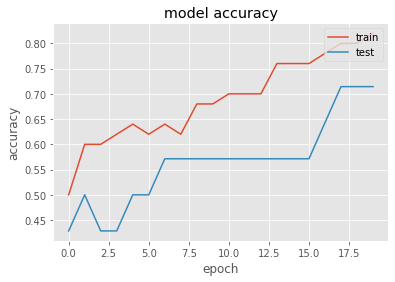

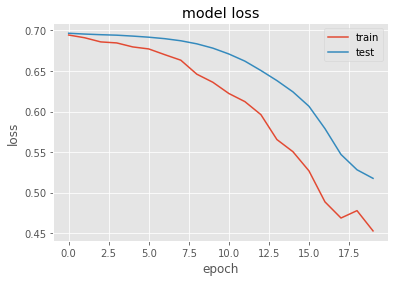

In [52]:
X_train, X_test, y_train, y_test = get_train_test(all_subjects_data_reshaped,
                                                    labels, i=8, verbrose=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=20)

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## Evaluate the LSTM model

In [53]:
from sklearn.metrics import accuracy_score

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=10, n_epochs=5):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootstrapping iterations 
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_subjects_data_reshaped,
                                              labels, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs)
    
    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
    
    acc_score = accuracy_score(y_test_1d, y_pred_1d)
    
    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr 



accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr  = boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test)

fitting..
Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.5549 - binary_accuracy: 0.6400 - val_loss: 0.3443 - val_binary_accuracy: 0.7857
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.5372 - binary_accuracy: 0.6800 - val_loss: 0.3738 - val_binary_accuracy: 0.7143
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.5459 - binary_accuracy: 0.6800 - val_loss: 0.3951 - val_binary_accuracy: 0.7143
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.5502 - binary_accuracy: 0.6800 - val_loss: 0.3959 - val_binary_accuracy: 0.7143
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.5498 - binary_accuracy: 0.6800 - val_loss: 0.3809 - val_binary_accuracy: 0.7143
evaluating..
fitting..
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.4835 - binary_accuracy: 0.6800 - val_loss: 0.4898 - val_binary_accuracy: 0.5714
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss:

In [54]:
def calc_p_val(stats, h0):
  '''
  finds the p value for the results 
  
  '''
  # calc pval
  tset, pval = ttest_1samp(stats, h0)

  return pval

p_val=calc_p_val(accuracy, .5)

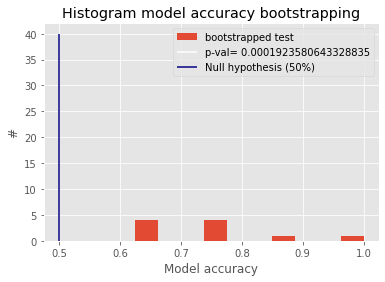

In [55]:
def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''
  
  plt.hist(stats, label='bootstrapped test')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')

  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()

plot_p_value(accuracy, p_val)

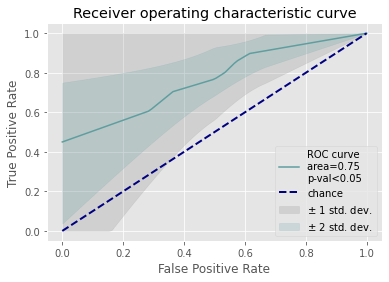

In [56]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped 
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
  tprs=[interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)
  
  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)
  

  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue', 
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2), 
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
  
  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')
  
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)